In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

presentation feedback
- Nice summaries of the Time Bandits! Taking that and converting into a slide would be be helpful.
- I’m not sure if the IQR stat that you threw out was accurate? The middle half of users are using between x and y would be more accurate.
- Take what you have in the .describe table by GPU and pull out the most interesting information into a slide.
- Are there certain uses which are more likely to request the max time (especially if they are not using it)?
- Instead of showing code and a dataframe, maybe you want to put your results in slides and show the results in simple charts. THe dataframes are great but most of their information cannot be read/interpreted during the short time of the presentation.
- Slides would help keep your presentation focused and concise with respect to time
- Great storytelling!

Import Dataframe

In [2]:
raw = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv',
                 on_bad_lines='warn',
                 engine='python') 

Skipping line 124084: Expected 12 fields in line 124084, saw 13
Skipping line 124809: Expected 12 fields in line 124809, saw 13


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      336950 non-null  object
 1   ACCOUNT    336950 non-null  object
 2   USER       336950 non-null  object
 3   USEDMEM    336950 non-null  object
 4   REQTIME    336950 non-null  object
 5   USEDTIME   336950 non-null  object
 6   NODES      336950 non-null  int64 
 7   CPUS       336950 non-null  int64 
 8   GPUS       336950 non-null  int64 
 9   PARTITION  336950 non-null  object
 10  EXITCODE   336950 non-null  object
 11  STATE      336950 non-null  object
dtypes: int64(3), object(9)
memory usage: 30.8+ MB


In [4]:
com_job=raw[raw["STATE"] == 'COMPLETED'].copy()
com_job

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96M,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70M,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21M,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52M,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED


In [5]:
#Stripping, cleaning, and type changing USEDMEM
com_job['USEDMEM'] = com_job['USEDMEM'].str.replace('M', '').astype(float)
#Stripping, cleaning, and type changing, and refactoring REQTIME
com_job['REQTIME'] = pd.to_timedelta(com_job['REQTIME'].str.replace('-',' days ')).dt.total_seconds()
#Calculated column for hours of requested time (Credit to team TWIX)
com_job["req_time_hours"] = com_job["REQTIME"]/3600
#Stripping, cleaning, and type changing, and refactoring USEDTIME
com_job['USEDTIME'] = pd.to_timedelta(com_job['USEDTIME'].str.replace('-',' days ')).dt.total_seconds()
#Calculated column for hours of used time (Credit to team TWIX)
com_job["used_time_hours"] = com_job["USEDTIME"]/3600
#Calculated column for ratio of used time and requested time(percent of time used of requested)
com_job["req_used_ratio"] = ((com_job['USEDTIME'] / com_job['REQTIME']))
#Calculated column for difference in requested time and used time in seconds
com_job["req_dif_sec"] = ((com_job['REQTIME'] - com_job['USEDTIME']))
#Calculated column for difference in requested and used time in hours
com_job["req_dif_hour"] = (com_job["REQTIME"] - com_job["USEDTIME"])/3600
com_job['GPUS'] = com_job['GPUS'].astype(str).str.zfill(2)
#Changing datatypes of columns (maybe very unnessisary)
#com_job['CPUS'] = com_job['CPUS'].astype(str)
#com_job['GPUS'] = com_job['GPUS'].astype(str)

# Would it be useful to know the distribution of the ratio of requested vs. used time in terms of completed jobs?

In [6]:
com_job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283333 entries, 0 to 336948
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   JOBID            283333 non-null  object 
 1   ACCOUNT          283333 non-null  object 
 2   USER             283333 non-null  object 
 3   USEDMEM          283333 non-null  float64
 4   REQTIME          283333 non-null  float64
 5   USEDTIME         283333 non-null  float64
 6   NODES            283333 non-null  int64  
 7   CPUS             283333 non-null  int64  
 8   GPUS             283333 non-null  object 
 9   PARTITION        283333 non-null  object 
 10  EXITCODE         283333 non-null  object 
 11  STATE            283333 non-null  object 
 12  req_time_hours   283333 non-null  float64
 13  used_time_hours  283333 non-null  float64
 14  req_used_ratio   283333 non-null  float64
 15  req_dif_sec      283333 non-null  float64
 16  req_dif_hour     283333 non-null  floa

In [7]:
com_job.head(n=1)

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,req_time_hours,used_time_hours,req_used_ratio,req_dif_sec,req_dif_hour
0,32880657,malanga,arline,18.66,172800.0,793.0,1,2,01,pascal,0:0,COMPLETED,48.0,0.220278,0.004589,172007.0,47.779722


# Count of all jobs by account across all Partitions.

Who are our top "Time Bandits"?

In [8]:
com_job['ACCOUNT'].value_counts().sort_index()

almonds             189
antares            3203
apple                45
bertanne            195
bunch                 1
cactus              113
clara                76
gem                  19
glasshouse       237060
grisette           5786
harovin            4729
horseradish          48
kinnow              380
malanga            9901
orange               74
packham               7
pasilla            1329
pecans              609
pinole               19
plumcot            1027
prince             7459
rosemarie            55
sugranineteen        31
summer                1
sunburst           1390
virginia           9556
white                31
Name: ACCOUNT, dtype: int64

# Time Bandits?

- Glasshouse, while not the most inefficient account, represented 83.67% of all completed jobs across all partitions.  The average used time ratio for thier jobs was 4.3%
- Virginia accounted for 3.4% of completed jobs. They used and average of 4.2% of time requested across all partitions.
- Malanga accounted for 3.5% of completed jobs.  They used an average of .52% of time requested
- Prince accounted for 2.6% of completed jobs. They used an average 0f 35.6% of time requested
- Grisette acconted for 2% of completed jobs.  They used an average of 3.6% of requested time.

In [9]:
com_job.groupby('ACCOUNT')['req_used_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
ACCOUNT,,,,,,,,
almonds,189.0,0.129661,0.249864,0.000017,0.000775,0.021447,0.104803,1.010000
antares,3203.0,0.131676,0.183848,0.000072,0.039395,0.069824,0.140028,1.483333
apple,45.0,0.097465,0.197727,0.000005,0.000197,0.029579,0.114437,0.903252
bertanne,195.0,0.129913,0.208304,0.000000,0.002222,0.020000,0.201782,1.001667
bunch,1.0,0.628333,NaN,0.628333,0.628333,0.628333,0.628333,0.628333
cactus,113.0,0.070017,0.222956,0.000008,0.002842,0.008136,0.027408,1.283333
clara,76.0,0.716600,0.406131,0.000009,0.397928,1.000013,1.000046,1.000148
gem,19.0,0.007620,0.009488,0.000226,0.000347,0.008715,0.009332,0.042153
glasshouse,237060.0,0.042731,0.119024,0.000000,0.001111,0.005583,0.011111,1.934722


In [10]:
com_job.groupby('USER')['req_used_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
USER,,,,,,,,
abigail,157.0,0.165378,0.238699,0.000024,0.002706,0.075556,0.229167,1.001667
adalyn,2.0,0.094954,0.110715,0.016667,0.055810,0.094954,0.134097,0.173241
adolfo,3.0,0.695008,0.530668,0.082245,0.541609,1.000972,1.001389,1.001806
alba,9.0,0.211860,0.061307,0.143212,0.163003,0.175069,0.259896,0.300677
aleah,8.0,0.254870,0.384806,0.002153,0.015451,0.061389,0.308455,1.001042
...,...,...,...,...,...,...,...,...
venus,16.0,0.023396,0.025101,0.002234,0.006597,0.012824,0.038611,0.086806
whitley,58.0,0.845473,0.332836,0.001360,1.000087,1.001028,1.002639,1.011111
wilhelmina,7454.0,0.355633,0.361599,0.000139,0.023837,0.198333,0.562691,1.483333


In [11]:
time_bandits = com_job.sort_values('count').describe()

KeyError: 'count'

In [ ]:
#unique partitions
com_job['PARTITION'].unique()

# Overall distribution of the percent of actual time used vs. requested time.

 - Across all partitions, the average user utiliezed 5.5% of the time that they requested.  50% of users utiliize 1.3% of the time that the request (#IQR - 0.013329.)
- At-least half of all users only utilize 1.3% percent of the times they request.


In [19]:
com_job["req_used_ratio"].describe()

count    283333.000000
mean          0.054817
std           0.154017
min           0.000000
25%           0.001139
50%           0.005472
75%           0.014468
max           1.934722
Name: req_used_ratio, dtype: float64

# Distribution of percent of actual time used vs. requested time

In [20]:
com_job.groupby('PARTITION')['req_used_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,127043.0,0.017691,0.088038,0.0,0.000278,0.005000,0.006222,1.100000
pascal,81314.0,0.088328,0.215047,0.0,0.001275,0.004921,0.018819,1.483333
turing,74976.0,0.081381,0.148649,0.0,0.003611,0.027500,0.108889,1.934722


- maxwell 
    - average  use use/request ratio of 1.8% (0.017691)
- pascal
    - average  use use/request ratio of 8.8% (0.088328) of the requested time
- turing 
    - average  use use/request ratio of 8.1% (0.081381)of the requested time

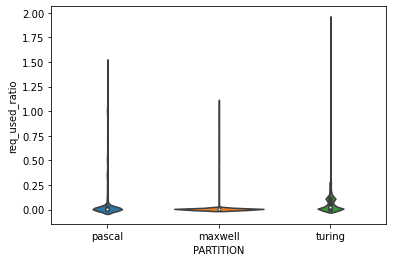

<Figure size 432x288 with 0 Axes>

In [21]:
#TEST
sns.violinplot(x='PARTITION', y='req_used_ratio', data=com_job)
plt.show()
plt.savefig("output.jpg")

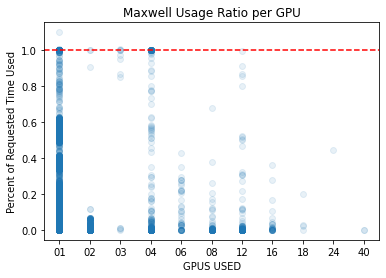

In [22]:
#USAGE RATIO OF GPUS Across Maxwell Partition
plot_df = com_job.loc[com_job['PARTITION'] == 'maxwell'].sort_values('GPUS')
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"], alpha = 0.1)
plt.xlabel("GPUS USED")
plt.ylabel("Percent of Requested Time Used")
plt.title("Maxwell Usage Ratio per GPU")
plt.axhline(y=1, color='r', linestyle='--')

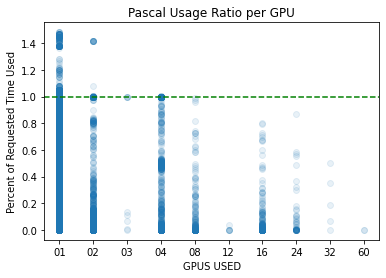

In [23]:
#USAGE RATIO OF GPUS Across Pascal Partition
plot_df = com_job.loc[com_job['PARTITION'] == 'pascal'].sort_values('GPUS')
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"], alpha = 0.1)
plt.xlabel("GPUS USED")
plt.ylabel("Percent of Requested Time Used")
plt.title("Pascal Usage Ratio per GPU")
plt.axhline(y=1, color='g', linestyle='--')

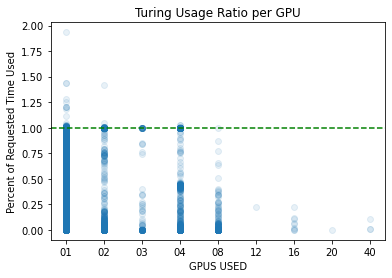

In [24]:
#USAGE RATIO OF GPUS Across Turing Partition
plot_df = com_job.loc[com_job['PARTITION'] == 'turing'].sort_values('GPUS')
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"], alpha = 0.1)
plt.xlabel("GPUS USED")
plt.ylabel("Percent of Requested Time Used")
plt.title("Turing Usage Ratio per GPU")
plt.axhline(y=1, color='g', linestyle='--')

# Distribution of usage ratio for GPUS across all partitions.
- on average, jobs that request 3 to 4 GPUs tend to have a higher ratio of used time to requested time
    - Jobs with 3 GPUs, on average, use 34% of the time requested.  However 50% of users utilize 86% of the time requested.
    - Jobs with 4 GPUs, on average, use 30% of the time requested. However 50% of users utilize 51% of the time requested.
- Jobs with 1 GPU are the most popular use-case across all partitoins.  However, the average 1 GPU job uses 5.3% of the requested time. However 50% of users utilize 1.2% of the time requested.

In [25]:
com_job.groupby('GPUS')['req_used_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
GPUS,,,,,,,,
01,274861.0,0.052625,0.148062,0.000000,0.001139,0.005444,0.013488,1.934722
02,5470.0,0.072503,0.210354,0.000005,0.002283,0.008532,0.027506,1.418015
03,107.0,0.336250,0.429452,0.000019,0.000405,0.051076,0.860057,1.004028
04,1831.0,0.301966,0.391386,0.000000,0.000557,0.028935,0.507711,1.029167
06,44.0,0.106673,0.118232,0.000017,0.001205,0.042514,0.217052,0.426681
08,517.0,0.078108,0.171366,0.000000,0.000028,0.001460,0.059025,1.000017
12,165.0,0.061489,0.179146,0.000000,0.000019,0.000056,0.011108,0.996840
16,276.0,0.068949,0.150855,0.000007,0.000183,0.007300,0.047096,0.804269
18,4.0,0.064014,0.092566,0.001722,0.018660,0.026292,0.071646,0.201750


# How many users are requesting the maximum time?

- 9.5% of completed jobs request at-least the maximum amount of time.

In [26]:
#Of all completed jobs across all partitions.
com_job[com_job["req_time_hours"] >= 120].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26807 entries, 327 to 336942
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JOBID            26807 non-null  object 
 1   ACCOUNT          26807 non-null  object 
 2   USER             26807 non-null  object 
 3   USEDMEM          26807 non-null  float64
 4   REQTIME          26807 non-null  float64
 5   USEDTIME         26807 non-null  float64
 6   NODES            26807 non-null  int64  
 7   CPUS             26807 non-null  int64  
 8   GPUS             26807 non-null  object 
 9   PARTITION        26807 non-null  object 
 10  EXITCODE         26807 non-null  object 
 11  STATE            26807 non-null  object 
 12  req_time_hours   26807 non-null  float64
 13  used_time_hours  26807 non-null  float64
 14  req_used_ratio   26807 non-null  float64
 15  req_dif_sec      26807 non-null  float64
 16  req_dif_hour     26807 non-null  float64
dtypes: float6

In [27]:
com_job[com_job["req_time_hours"] >= 120]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,req_time_hours,used_time_hours,req_used_ratio,req_dif_sec,req_dif_hour
327,32884086,glasshouse,miya,374.89,432000.0,117514.0,1,1,01,pascal,0:0,COMPLETED,120.0,32.642778,0.272023,314486.0,87.357222
1063,32891995,glasshouse,erick,242.00,432000.0,416671.0,1,1,01,pascal,0:0,COMPLETED,120.0,115.741944,0.964516,15329.0,4.258056
1064,32891996,glasshouse,erick,244.33,432000.0,416671.0,1,1,01,pascal,0:0,COMPLETED,120.0,115.741944,0.964516,15329.0,4.258056
1065,32891997,glasshouse,erick,243.17,432000.0,416671.0,1,1,01,pascal,0:0,COMPLETED,120.0,115.741944,0.964516,15329.0,4.258056
1066,32891998,glasshouse,erick,243.82,432000.0,416671.0,1,1,01,pascal,0:0,COMPLETED,120.0,115.741944,0.964516,15329.0,4.258056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336929,46753800,harovin,shannon,160.03,432000.0,37.0,1,1,01,turing,0:0,COMPLETED,120.0,0.010278,0.000086,431963.0,119.989722
336933,46753813,harovin,shannon,137.96,432000.0,52.0,1,1,01,turing,0:0,COMPLETED,120.0,0.014444,0.000120,431948.0,119.985556
336934,46753820_26,harovin,porsha,5093.70,432000.0,2091.0,1,6,01,turing,0:0,COMPLETED,120.0,0.580833,0.004840,429909.0,119.419167
336936,46753823,harovin,shannon,156.21,432000.0,243.0,1,1,01,turing,0:0,COMPLETED,120.0,0.067500,0.000563,431757.0,119.932500


# Distribution of Jobs that use 5 or more hours
- The average job that request 5 or more hours utilizes 8.1% of the time requested.
- 50% of jobs that request 5 or more hours ulize 1.5% of the time requested.

In [28]:
# Distribution of jobs that request 5 or more days to complete.
com_job[com_job["req_time_hours"] >= 120].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,req_time_hours,used_time_hours,req_used_ratio,req_dif_sec,req_dif_hour
count,26807.000000,2.680700e+04,26807.000000,26807.000000,26807.000000,26807.000000,26807.000000,26807.000000,26807.000000,26807.000000
mean,4646.352094,4.321064e+05,35253.354795,1.007535,1.875256,120.029545,9.792599,0.081529,396853.005484,110.236946
std,4736.170789,8.908185e+03,95107.902292,0.123444,2.119507,2.474496,26.418862,0.219917,95166.177213,26.435049
min,0.000000,4.320000e+05,0.000000,1.000000,1.000000,120.000000,0.000000,0.000000,-266.000000,-0.073889
25%,3124.915000,4.320000e+05,559.000000,1.000000,1.000000,120.000000,0.155278,0.001294,424767.500000,117.990972
50%,3541.830000,4.320000e+05,2625.000000,1.000000,1.000000,120.000000,0.729167,0.006076,429378.000000,119.271667
75%,6055.485000,4.320000e+05,7242.500000,1.000000,1.000000,120.000000,2.011806,0.016765,431441.000000,119.844722
max,102095.660000,1.296000e+06,702934.000000,5.000000,40.000000,360.000000,195.259444,1.000616,985570.000000,273.769444


In [29]:
# Information about jobs that require at-least 5 days.
com_job[com_job["used_time_hours"] >= 120].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 1825 to 335583
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JOBID            750 non-null    object 
 1   ACCOUNT          750 non-null    object 
 2   USER             750 non-null    object 
 3   USEDMEM          750 non-null    float64
 4   REQTIME          750 non-null    float64
 5   USEDTIME         750 non-null    float64
 6   NODES            750 non-null    int64  
 7   CPUS             750 non-null    int64  
 8   GPUS             750 non-null    object 
 9   PARTITION        750 non-null    object 
 10  EXITCODE         750 non-null    object 
 11  STATE            750 non-null    object 
 12  req_time_hours   750 non-null    float64
 13  used_time_hours  750 non-null    float64
 14  req_used_ratio   750 non-null    float64
 15  req_dif_sec      750 non-null    float64
 16  req_dif_hour     750 non-null    float64
dtypes: float64

In [30]:
#Distribution of Jobs that use at-least 5 days
com_job[com_job["used_time_hours"] >= 120].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,req_time_hours,used_time_hours,req_used_ratio,req_dif_sec,req_dif_hour
count,750.000000,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,7344.252813,4.328063e+05,432379.797333,1.004000,3.000000,120.223978,120.105499,0.999614,426.522667,0.118479
std,11346.422621,2.208418e+04,9892.448777,0.081606,2.290632,6.134493,2.747902,0.011760,12191.757134,3.386599
min,0.000000,4.319400e+05,432001.000000,1.000000,1.000000,119.983333,120.000278,0.677984,-266.000000,-0.073889
25%,299.322500,4.320000e+05,432008.250000,1.000000,1.000000,120.000000,120.002292,1.000019,-24.000000,-0.006667
50%,3143.960000,4.320000e+05,432016.000000,1.000000,2.000000,120.000000,120.004444,1.000037,-16.000000,-0.004444
75%,7789.292500,4.320000e+05,432024.000000,1.000000,5.000000,120.000000,120.006667,1.000056,-8.250000,-0.002292
max,52411.830000,1.036800e+06,702934.000000,3.000000,21.000000,288.000000,195.259444,1.000616,333866.000000,92.740556


In [31]:
time_bandits = com_job[com_job["req_time_hours"] >= 120]
time_bandits.groupby('USER')["req_used_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
USER,,,,,,,,
andra,31.0,0.871484,0.339499,0.000014,1.000010,1.000019,1.000039,1.000069
archie,36.0,0.328468,0.112436,0.000049,0.309851,0.359425,0.381219,0.505644
birdella,402.0,0.566001,0.274232,0.000007,0.473895,0.651735,0.758027,1.000074
booker,1.0,0.098226,NaN,0.098226,0.098226,0.098226,0.098226,0.098226
brittani,5.0,0.722084,0.390898,0.179014,0.431343,1.000007,1.000009,1.000049
brodie,4.0,0.345639,0.120433,0.239529,0.243248,0.338643,0.441034,0.465741
burdette,1.0,0.000313,NaN,0.000313,0.000313,0.000313,0.000313,0.000313
christian,11.0,0.092178,0.297609,0.000919,0.001778,0.002519,0.003080,0.989495
cleva,19.0,0.106270,0.200608,0.000197,0.027377,0.059025,0.093676,0.903252
